### Домашня работа 2.
### Логистическая регрессия. Работа с признаками


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 15 баллов. Можно получить 4.5 бонусных балла.

Неэффективная реализация кода может негативно отразиться на оценке.

In [1]:
print('Всем удачи!👒 Тут она точно пригодится.')

Всем удачи!👒 Тут она точно пригодится.


In [2]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Часть 1. Логистическая регрессия своими руками (4 балла)

Синтетические данные

In [3]:
%pylab inline
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

**Задание 3 (1 балл)**

Обучите логистическую регрессию на синтетических данных.

In [21]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import r2_score
lr_mse = SGDClassifier(loss='log_loss')

lr_mse.fit(X_train, y_train)

pred_mse = lr_mse.predict(X_test)

r2_score(y_test, pred_mse)

0.3587958848944792

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

0.7855115471475105
0.9189467820406811


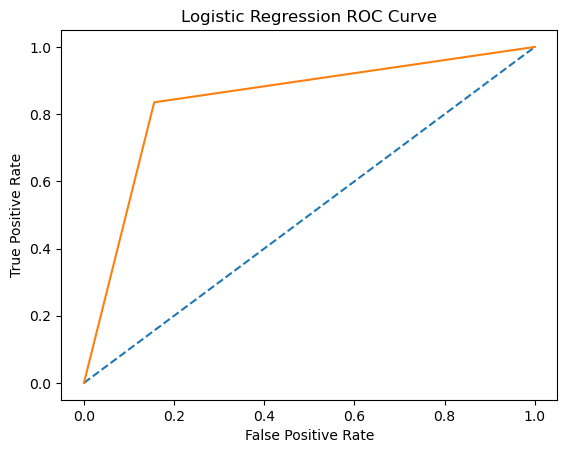

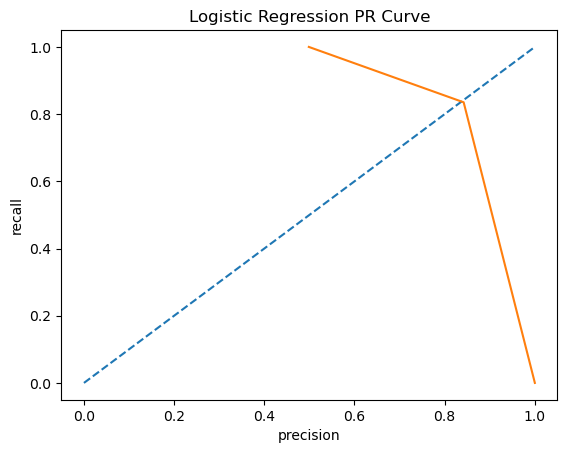

In [36]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

print(average_precision_score(y_test, pred_mse))
print(roc_auc_score(y_test, lr_mse.predict_proba(X_test)[:, 1]))

fpr, tpr, tresholds = roc_curve(y_test,pred_mse)
precision, recall, thresholds = precision_recall_curve(y_test, pred_mse)

plt.plot([0,1],[0,1],'--')
plt.plot(fpr,tpr,)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
plt.show()


plt.plot([0,1],[0,1],'--')
plt.plot(precision,recall,)
plt.xlabel("precision")
plt.ylabel("recall")
plt.title("Logistic Regression PR Curve")
plt.show()


## Часть 2. Работа с категориальными переменными (3 балла)

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные с конкурса  [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом для задания мы немного модифицируем датасет.

In [58]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.


In [138]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

**Задание 5 (0 баллов).** Посчитайте качество (в этом задании будем работать c ROC-AUC) на исходных признаках при применении логистической регрессии.

In [139]:
lr_mse.fit(X_train, y_train)

pred_mse = lr_mse.predict(X_test)

print(roc_auc_score(y_test, lr_mse.predict_proba(X_test)[:, 1]))

0.5640354126545369


**Задание 6 (0.5 балла).** Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на обучение модели.

In [81]:
import pandas as pd
filtered_cols = list(filter(lambda col: 'cat' in col, X_train.columns))
X_dum = pd.get_dummies((X_train[filtered_cols]).astype(str), drop_first=True)
X_train_oh = pd.concat([X_train.drop(columns = filtered_cols, axis = 'columns'),X_dum], axis=1)

filtered_cols = list(filter(lambda col: 'cat' in col, X_test.columns))
X_dum = pd.get_dummies((X_test[filtered_cols]).astype(str), drop_first=True)
X_test_oh = pd.concat([X_test.drop(columns = filtered_cols, axis = 'columns'), X_dum], axis=1)

In [145]:
import time

start_time = time.time()

lr_mse.fit(X_train_oh, y_train)

pred_mse = lr_mse.predict(X_test_oh)

print(roc_auc_score(y_test, lr_mse.predict_proba(X_test_oh)[:, 1]))

end_time = time.time()
execution_time = end_time - start_time

print(f"Время выполнения: {execution_time} секунд")


0.6309993755947614
Время выполнения: 7.575436353683472 секунд


Как можно было заменить, one-hot-кодирование сильно увилечивает количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 7 (1.5 балла).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментом. Заметили ли вы что-то интересное?


In [172]:
X_train_y = X_train
X_train_y['y'] = y_train

In [175]:
import numpy as np

def mean_encoding(train, target, category):
    mean_values = train.groupby(category)[target].mean()
    encoded = train[category].map(mean_values)
    return encoded
for i in range(train.shape()):
    mean_encoding(X_train_y, 'y', 'ps_ind_02_cat')

TypeError: Cannot index by location index with a non-integer key

In [198]:
X_train.iloc[1,2]

6

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо так, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 8 (1 балл)__. Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.


In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

## Часть 3. Отбор признаков (3 балла + 1 бонус)

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом они увеличивают время вычислений) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про обращение клиентов по страховым случаям. Обойдёмся без сэмплирования объектов.

In [199]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

Как вы помните, в данных много категориальных признаков. Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [200]:
filtered_cols = list(filter(lambda col: 'cat' in col, X_train.columns))
X_dum = pd.get_dummies((X_train[filtered_cols]).astype(str), drop_first=True)
X_train_oh = pd.concat([X_train.drop(columns = filtered_cols, axis = 'columns'),X_dum], axis=1)

filtered_cols = list(filter(lambda col: 'cat' in col, X_test.columns))
X_dum = pd.get_dummies((X_test[filtered_cols]).astype(str), drop_first=True)
X_test_oh = pd.concat([X_test.drop(columns = filtered_cols, axis = 'columns'), X_dum], axis=1)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — ROC-AUC. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [203]:
print('Кол-во новых стобцов ', X_dum.shape[1])

Кол-во новых стобцов  170


In [206]:
lr_mse.fit(X_train_oh, y_train)

pred_mse = lr_mse.predict(X_test_oh)

print('Roc-auc: ', roc_auc_score(y_test, lr_mse.predict_proba(X_test_oh)[:, 1]))



Roc-auc:  0.628010018814043


### Встроенные методы

Допустим, мы хотим оставить только 200 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 10 (1 балл).__ Оставьте 200 признаков с наибольшим модулем соответсвующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?

In [210]:
from sklearn.feature_selection import SelectKBest, f_regression

start_time = time.time()

selector = SelectKBest(score_func=f_regression, k=200)
X_train_selected = selector.fit_transform(X_train_oh, y_train)
X_test_selected = selector.transform(X_test_oh)

end_time = time.time()
execution_time = end_time - start_time
print(f"Время выполнения: {execution_time} секунд")

Время выполнения: 4.251310586929321 секунд


In [211]:
lr_mse.fit(X_train_selected, y_train)

pred_mse = lr_mse.predict(X_test_selected)

print('Roc-auc: ', roc_auc_score(y_test, lr_mse.predict_proba(X_test_selected)[:, 1]))


Roc-auc:  0.6259535941630767


После отбора переменных качество практически не изменилось

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отнормируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [214]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(X_train_oh)
X_train_norm = MinMaxScaler().fit_transform(X_train_oh)
X_test_norm = MinMaxScaler().fit_transform(X_test_oh)

In [215]:
from sklearn.feature_selection import SelectKBest, f_regression

start_time = time.time()

selector = SelectKBest(score_func=f_regression, k=200)
X_train_selected = selector.fit_transform(X_train_norm, y_train)
X_test_selected = selector.transform(X_test_norm)

end_time = time.time()
execution_time = end_time - start_time
print(f"Время выполнения: {execution_time} секунд")

lr_mse.fit(X_train_selected, y_train)

pred_mse = lr_mse.predict(X_test_selected)

print('Roc-auc: ', roc_auc_score(y_test, lr_mse.predict_proba(X_test_selected)[:, 1]))


Время выполнения: 5.881757020950317 секунд
Roc-auc:  0.6353267392241574


По итогу нормализации признаков мы немного улучшили качество модели

__Задание 10 (0.5 балла).__
Можно задать отбор признаков более функционально. Вспомним, что L1-регуляризация также умеет отбирать признаки. Понятно, что теперь нам будет сложнее оставить именно 200 лучших признаков, но возможно они нам и не нужны. Подберите коэффициент регуляризации и проверьте, как изменилось качество. Получилось ли добиться лучшего качества при менее чем 200 признаках?

In [227]:
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=5)
lasso.fit(X_train_oh, y_train)
selected_features = lasso.coef_ != 0


C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9838598954156623, tolerance: 1.337796759027086
  model = cd_fast.enet_coordinate_descent_gram(
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.61216601757587, tolerance: 1.337796759027086
  model = cd_fast.enet_coordinate_descent_gram(
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.18603535665352, tolerance: 1.337796759027086
  model = cd_fast.enet_coordinate_descent_gram(
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. 

ValueError: Item wrong length 213 instead of 476169.

In [245]:
X_train_selected_l = pd.DataFrame(X_train_norm).iloc[:,selected_features]
X_test_selected_l = pd.DataFrame(X_test_norm).iloc[:,selected_features]

lr_mse.fit(X_train_selected_l, y_train)

pred_mse = lr_mse.predict(X_test_selected_l)

print('Roc-auc: ', roc_auc_score(y_test, lr_mse.predict_proba(X_test_selected_l)[:, 1]))

Roc-auc:  0.63438350537462


Отбор переменных с помощью L1-регуляризации не дало позитивного эффекта на качество модели.

### Методы фильтрации

**Задание 13 (0.5 балла)** Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

**Ответ:** ...

Roc-auc:  0.6356116960093595
